Data by:

R. J. Lyon, B. W. Stappers, S. Cooper, J. M. Brooke, J. D. Knowles, Fifty Years of Pulsar
Candidate Selection: From simple filters to a new principled real-time classification approach
MNRAS, 2016.

In [1]:
import torch
import torch.nn.init as init
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display


# create dataset

class Custom_Dataset(torch.utils.data.Dataset):

    def __init__(self,data,transform=None, target_transform=None):
        super().__init__()
        self.transform = transform
        self.target_transform = target_transform
        self.data =  data.values
        
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        variables = self.data[idx,0:8]
        label = self.data[idx,8]

        if self.transform:
            variables = self.transform(variables)
        if self.target_transform:
            label = self.target_transform(label)

        return variables, label



In [2]:
training_set_percentage = 0.8
batch_size = 64

# load data
df = pd.read_csv('HTRU\HTRU_2.csv', header=None)
df['split'] = np.random.randn(df.shape[0], 1)
df = df.astype("float32")

msk = np.random.rand(len(df)) <= training_set_percentage

train_data = df[msk]
test_data = df[~msk]

train_dataset = Custom_Dataset(data=train_data)
test_dataset = Custom_Dataset(data=test_data)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)




(dot.exe:5568): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


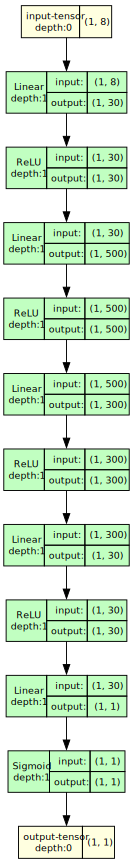

In [3]:
# create neural network

learning_rate = 0.001

class custom_Neural_Network(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(8, 30)
        self.act1 = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(30, 500)
        self.act2 = torch.nn.ReLU()
        self.layer3 = torch.nn.Linear(500, 300)
        self.act3 = torch.nn.ReLU()
        self.layer4 = torch.nn.Linear(300, 30)
        self.act4 = torch.nn.ReLU()
        self.output = torch.nn.Linear(30, 1)
        self.sigmoid = torch.nn.Sigmoid()


    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.act4(self.layer4(x))
        x = self.sigmoid(self.output(x))
        return x
    

    

# Neural_Network = torch.nn.Sequential(
#     torch.nn.Linear(8,60),  # 8 variables input
#     torch.nn.ReLU(),
#     torch.nn.Linear(60,100),
#     torch.nn.ReLU(),
#     torch.nn.Linear(100,30),
#     torch.nn.ReLU(),
#     torch.nn.Linear(30,1)) # 1 label output
#     torch.nn.Sigmoid(),


Neural_Network = custom_Neural_Network()
Loss_Function = torch.nn.BCEWithLogitsLoss()
Optimizer = torch.optim.SGD(params=Neural_Network.parameters(), lr=learning_rate)

from torchview import draw_graph;
model_graph = draw_graph(Neural_Network,  input_size=(1,8), expand_nested=True)
model_graph.visual_graph

In [4]:
def train_loop(dataloader, model, loss_fn, optimizer):
    losses=[]
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        optimizer.zero_grad()
        pred = model(X).squeeze()
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        losses.append(loss.sum().item())
    return losses


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X).squeeze()
            test_loss += loss_fn(pred, y).sum().item()

    test_loss /= size
    return test_loss

In [5]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score

def train_loop_with_metrics(dataloader, model, loss_fn, optimizer, max_gradient_norm=1.0):
    losses = []
    predictions = []
    true_labels = []
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        optimizer.zero_grad()
        pred = model(X).squeeze()
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()

        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_gradient_norm)

        optimizer.step()
        losses.append(loss.sum().item())

        # Collect predictions and true labels for metrics
        predictions.extend((pred > 0.5).int().tolist())
        true_labels.extend(y.int().tolist())

    return losses, predictions, true_labels

def calculate_metrics(predictions, true_labels):
    conf_matrix = confusion_matrix(true_labels, predictions)
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)

    return conf_matrix, accuracy, precision

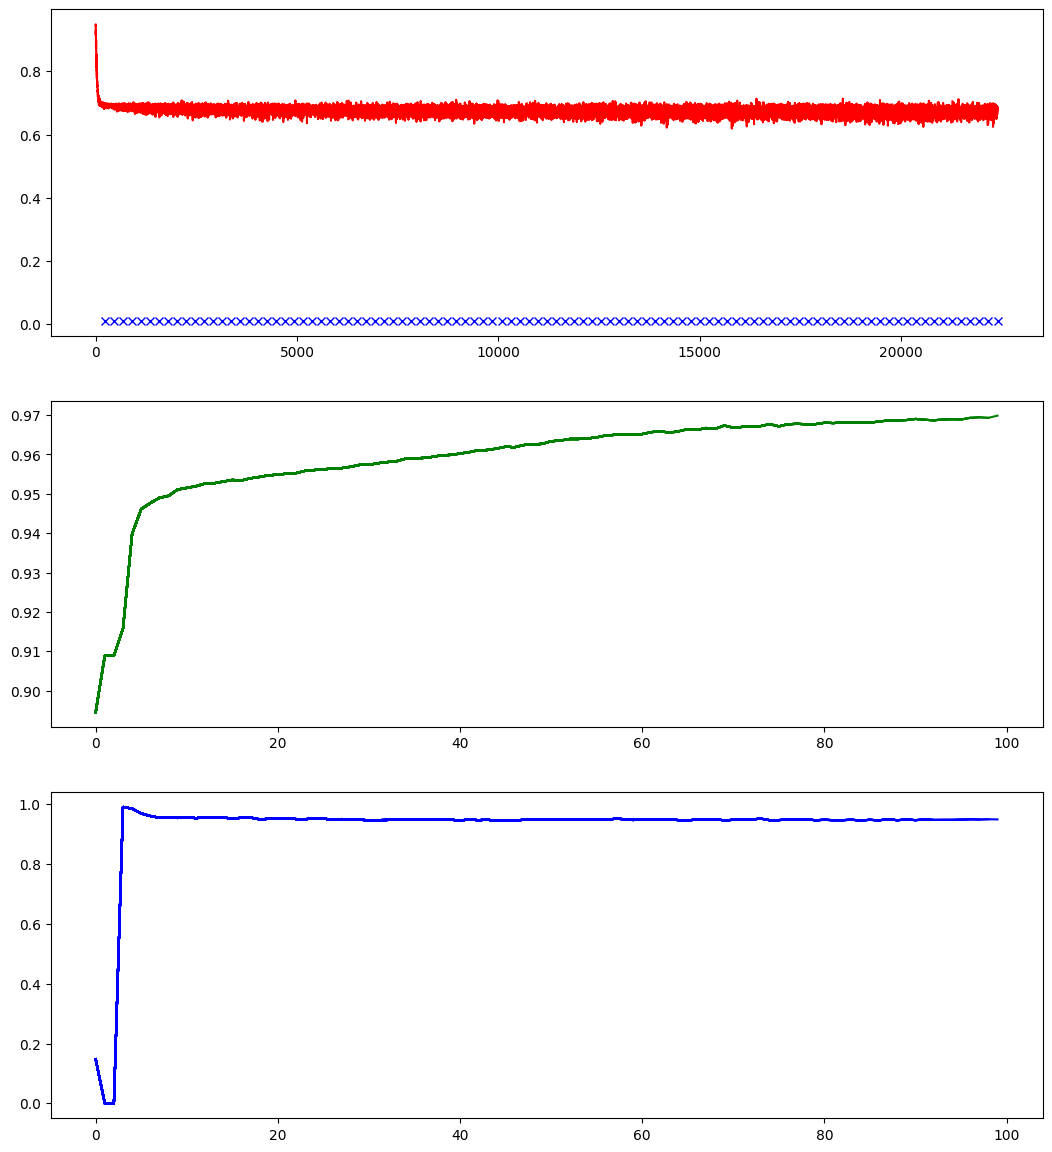

Epoch 1 - Accuracy: 0.8946, Precision: 0.1478


Epoch 3 - Accuracy: 0.9089, Precision: 0.0000


c:\Users\Torbe\OneDrive\Documents\Uni\Applied Machine Learning for engineers\Group project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4 - Accuracy: 0.9159, Precision: 0.9902
Epoch 5 - Accuracy: 0.9399, Precision: 0.9847
Epoch 6 - Accuracy: 0.9461, Precision: 0.9684
Epoch 7 - Accuracy: 0.9477, Precision: 0.9603
Epoch 8 - Accuracy: 0.9490, Precision: 0.9542
Epoch 9 - Accuracy: 0.9495, Precision: 0.9561
Epoch 10 - Accuracy: 0.9511, Precision: 0.9535
Epoch 11 - Accuracy: 0.9515, Precision: 0.9553
Epoch 12 - Accuracy: 0.9519, Precision: 0.9530
Epoch 13 - Accuracy: 0.9526, Precision: 0.9550
Epoch 14 - Accuracy: 0.9527, Precision: 0.9564
Epoch 15 - Accuracy: 0.9531, Precision: 0.9555
Epoch 16 - Accuracy: 0.9535, Precision: 0.9507
Epoch 17 - Accuracy: 0.9534, Precision: 0.9544
Epoch 18 - Accuracy: 0.9540, Precision: 0.9549
Epoch 19 - Accuracy: 0.9543, Precision: 0.9490
Epoch 20 - Accuracy: 0.9547, Precision: 0.9506
Epoch 21 - Accuracy: 0.9549, Precision: 0.9508
Epoch 22 - Accuracy: 0.9551, Precision: 0.9523
Epoch 23 - Accuracy: 0.9553, Precision: 0.9499
Epoch 24 - Accuracy: 0.9558, Precision: 0.9493
Epoch 25 - Accuracy

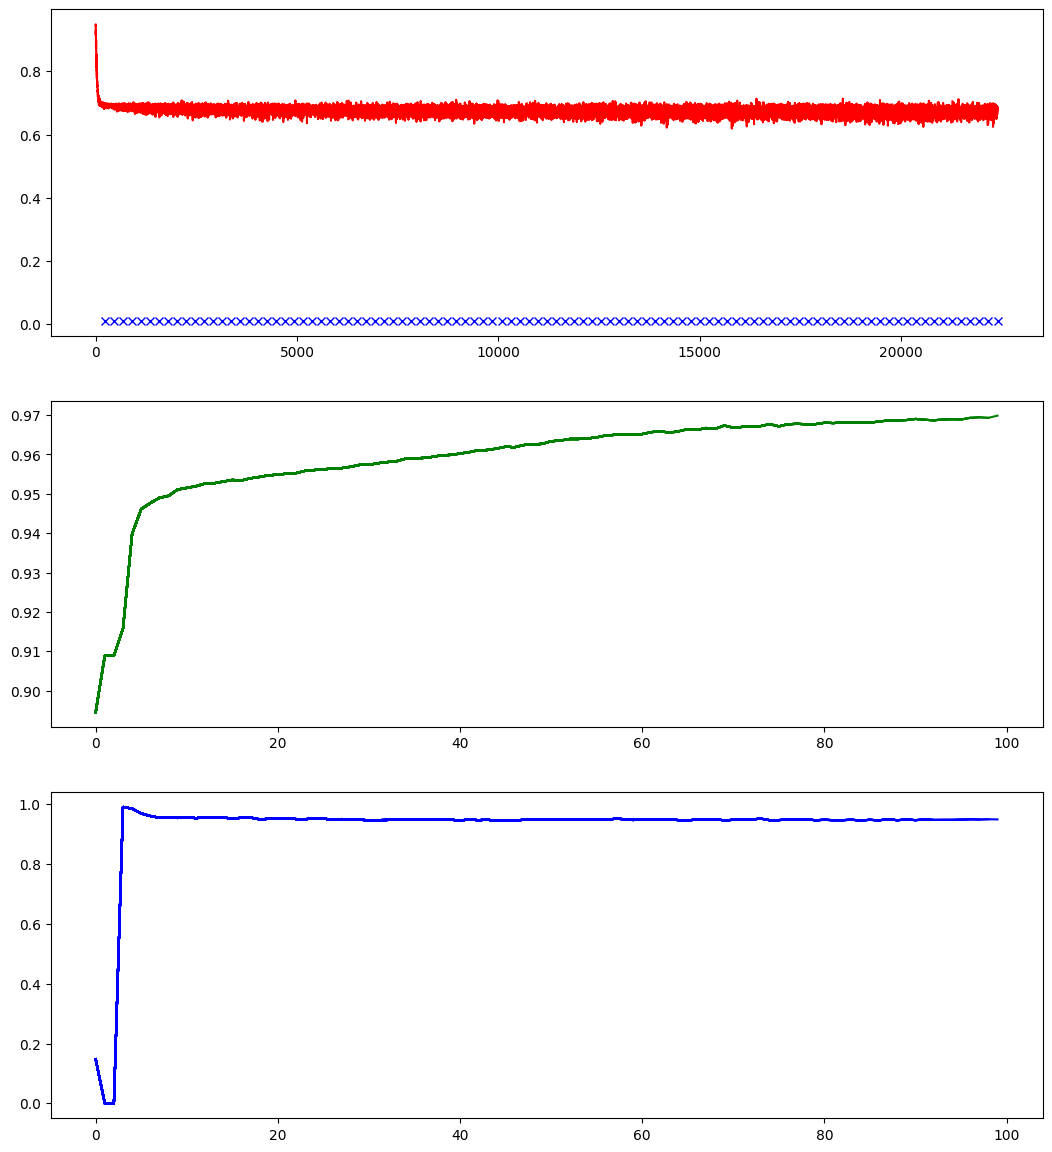

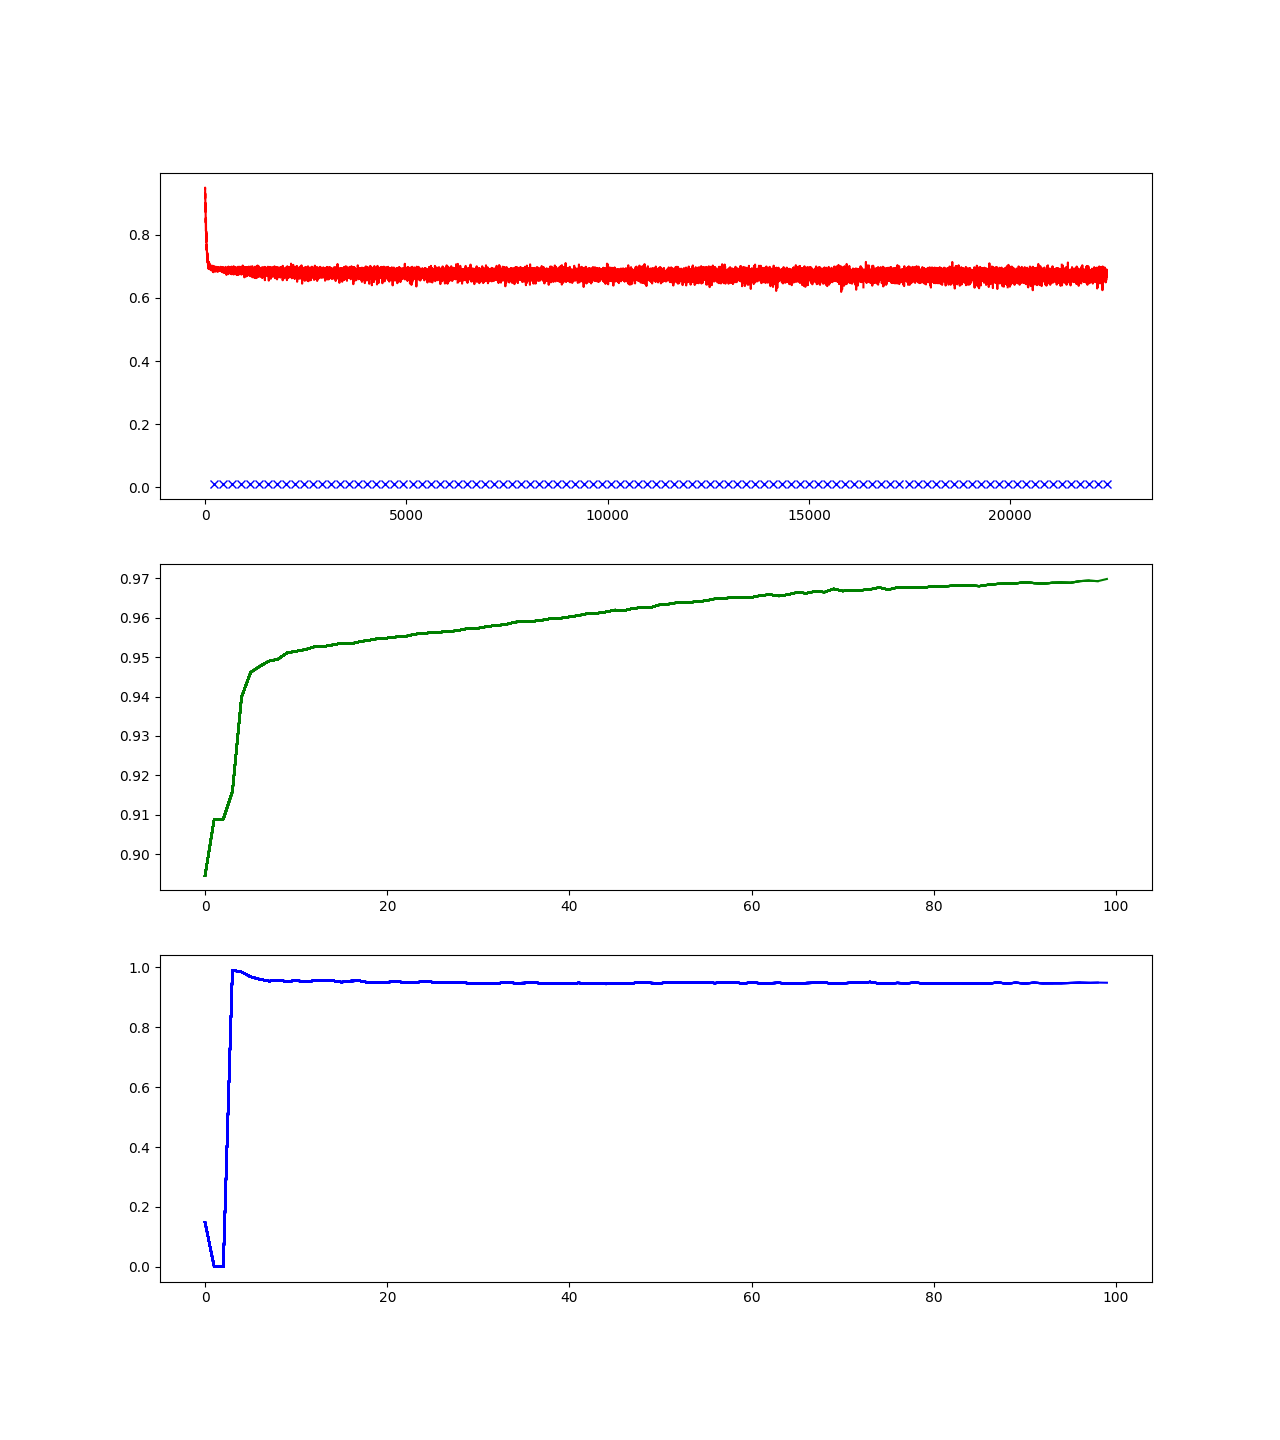

In [6]:
from IPython import display; hdisplay = display.display("", display_id=True)
%matplotlib widget

# Usage in your training loop
epochs = 100

train_losses = []
test_losses = []
gradient_norms_list = []
conf_matrices = []  # Collect confusion matrices for each epoch
accuracies = []  # Collect accuracies for each epoch
precisions = []  # Collect precisions for each epoch
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12.8, 14.4))

for t in range(epochs):
    current_train_losses, predictions, true_labels = train_loop_with_metrics(train_dataloader, Neural_Network, Loss_Function, Optimizer, max_gradient_norm=1.0)
    current_test_loss = test_loop(test_dataloader, Neural_Network, Loss_Function)

    train_losses.extend(current_train_losses)
    test_losses.append(current_test_loss)

    X1 = range(t * len(current_train_losses), (t + 1) * len(current_train_losses))
    X2 = (t + 1) * len(current_train_losses)

    ax1.plot(X1, current_train_losses, "r-", label="train loss")
    ax1.plot([X2], [current_test_loss], "bx", label="test loss")

    # Calculate and collect metrics
    conf_matrix, accuracy, precision = calculate_metrics(predictions, true_labels)
    conf_matrices.append(conf_matrix)
    accuracies.append(accuracy)
    precisions.append(precision)

    # Print metrics
    # if (t+1 % 10) == 0:
    print(f'Epoch {t + 1} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}')

    # Plot metrics
    ax2.plot(range(t + 1), accuracies, "g-", label="accuracy")
    ax3.plot(range(t + 1), precisions, "b-", label="precision")
    
    hdisplay.update(fig)

hdisplay.display(fig)
plt.show(fig)
plt.close(fig)



(dot.exe:13196): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


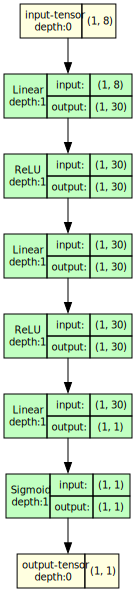

In [7]:
# define smaller and faster network

class custom_fast_Neural_Network(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(8, 30)
        self.act1 = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(30, 30)
        self.act2 = torch.nn.ReLU()
        self.output = torch.nn.Linear(30, 1)
        self.sigmoid = torch.nn.Sigmoid()


    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.sigmoid(self.output(x))
        return x
    

    

fast_Neural_Network = custom_fast_Neural_Network()
Loss_Function = torch.nn.BCEWithLogitsLoss()
Optimizer = torch.optim.SGD(params=fast_Neural_Network.parameters(), lr=learning_rate)

from torchview import draw_graph;
model_graph = draw_graph(fast_Neural_Network,  input_size=(1,8), expand_nested=True)
model_graph.visual_graph





''

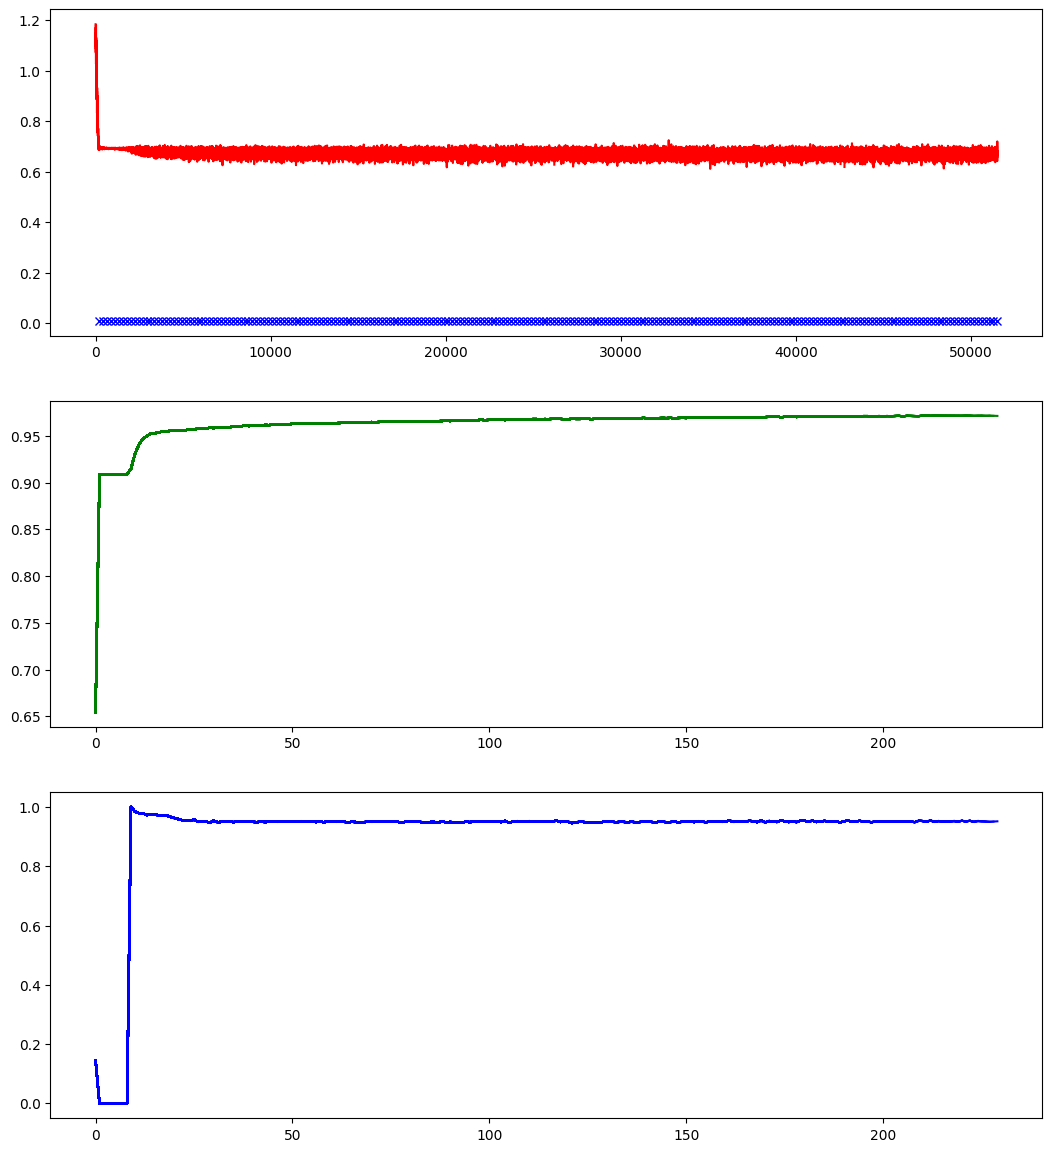

Epoch 1 - Accuracy: 0.6546, Precision: 0.1452
Epoch 2 - Accuracy: 0.9089, Precision: 0.0000


c:\Users\Torbe\OneDrive\Documents\Uni\Applied Machine Learning for engineers\Group project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Torbe\OneDrive\Documents\Uni\Applied Machine Learning for engineers\Group project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3 - Accuracy: 0.9089, Precision: 0.0000
Epoch 4 - Accuracy: 0.9089, Precision: 0.0000


c:\Users\Torbe\OneDrive\Documents\Uni\Applied Machine Learning for engineers\Group project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Torbe\OneDrive\Documents\Uni\Applied Machine Learning for engineers\Group project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5 - Accuracy: 0.9089, Precision: 0.0000
Epoch 6 - Accuracy: 0.9089, Precision: 0.0000


c:\Users\Torbe\OneDrive\Documents\Uni\Applied Machine Learning for engineers\Group project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7 - Accuracy: 0.9089, Precision: 0.0000


c:\Users\Torbe\OneDrive\Documents\Uni\Applied Machine Learning for engineers\Group project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8 - Accuracy: 0.9089, Precision: 0.0000


c:\Users\Torbe\OneDrive\Documents\Uni\Applied Machine Learning for engineers\Group project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9 - Accuracy: 0.9089, Precision: 0.0000


c:\Users\Torbe\OneDrive\Documents\Uni\Applied Machine Learning for engineers\Group project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10 - Accuracy: 0.9150, Precision: 1.0000
Epoch 11 - Accuracy: 0.9309, Precision: 0.9846
Epoch 12 - Accuracy: 0.9406, Precision: 0.9789
Epoch 13 - Accuracy: 0.9470, Precision: 0.9789
Epoch 14 - Accuracy: 0.9499, Precision: 0.9727
Epoch 15 - Accuracy: 0.9524, Precision: 0.9742
Epoch 16 - Accuracy: 0.9528, Precision: 0.9744
Epoch 17 - Accuracy: 0.9540, Precision: 0.9722
Epoch 18 - Accuracy: 0.9546, Precision: 0.9726
Epoch 19 - Accuracy: 0.9549, Precision: 0.9714
Epoch 20 - Accuracy: 0.9556, Precision: 0.9665
Epoch 21 - Accuracy: 0.9557, Precision: 0.9628
Epoch 22 - Accuracy: 0.9559, Precision: 0.9591
Epoch 23 - Accuracy: 0.9561, Precision: 0.9555
Epoch 24 - Accuracy: 0.9563, Precision: 0.9545
Epoch 25 - Accuracy: 0.9572, Precision: 0.9529
Epoch 26 - Accuracy: 0.9571, Precision: 0.9576
Epoch 27 - Accuracy: 0.9577, Precision: 0.9499
Epoch 28 - Accuracy: 0.9575, Precision: 0.9520
Epoch 29 - Accuracy: 0.9579, Precision: 0.9512
Epoch 30 - Accuracy: 0.9588, Precision: 0.9463
Epoch 31 - Ac

In [8]:
# train faster network
from IPython import display; hdisplay = display.display("", display_id=True)
%matplotlib widget

epochs = 1000

train_losses = []
test_losses = []
gradient_norms_list = []
conf_matrices = []  # Collect confusion matrices for each epoch
accuracies = []  # Collect accuracies for each epoch
precisions = []  # Collect precisions for each epoch
fig2, (ax4, ax5, ax6) = plt.subplots(3, 1, figsize=(12.8, 14.4))
hdisplay.display(fig2)

for t in range(epochs):
    current_train_losses, predictions, true_labels = train_loop_with_metrics(train_dataloader, fast_Neural_Network, Loss_Function, Optimizer, max_gradient_norm=1.0)
    current_test_loss = test_loop(test_dataloader, fast_Neural_Network, Loss_Function)

    train_losses.extend(current_train_losses)
    test_losses.append(current_test_loss)

    X1 = range(t * len(current_train_losses), (t + 1) * len(current_train_losses))
    X2 = (t + 1) * len(current_train_losses)

    ax4.plot(X1, current_train_losses, "r-", label="train loss")
    ax4.plot([X2], [current_test_loss], "bx", label="test loss")

    # Calculate and collect metrics
    conf_matrix, accuracy, precision = calculate_metrics(predictions, true_labels)
    conf_matrices.append(conf_matrix)
    accuracies.append(accuracy)
    precisions.append(precision)

    # Print metrics
    print(f'Epoch {t + 1} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}')

    # Plot metrics
    ax5.plot(range(t + 1), accuracies, "g-", label="accuracy")
    ax6.plot(range(t + 1), precisions, "b-", label="precision")
    
    hdisplay.update(fig2)

plt.show()
plt.close(fig2)
